<a href="https://colab.research.google.com/github/parlakisik/packetinspector/blob/main/ai/trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading packages

In [8]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten , Activation, SimpleRNN, LSTM, GRU, Dropout, TimeDistributed, Reshape, Input, Lambda, Add
from tensorflow.keras import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [9]:
# prompt: show files in current directory

!ls -al train_files/


total 137392
drwxr-xr-x 2 root root     4096 Apr 13 20:06  .
drwxr-xr-x 1 root root     4096 Apr 13 20:06  ..
-rw-r--r-- 1 root root     4044 Apr 13 20:06  NUSW-NB15_features.csv
-rw-r--r-- 1 root root   189112 Apr 13 20:06 'The UNSW-NB15 description.pdf'
-rw-r--r-- 1 root root 42775611 Apr 13 20:08  UNSW-NB15_1.csv.gz
-rw-r--r-- 1 root root 43244175 Apr 13 20:08  UNSW-NB15_2.csv.gz
-rw-r--r-- 1 root root 33168775 Apr 13 20:07  UNSW-NB15_3.csv.gz
-rw-r--r-- 1 root root 21277181 Apr 13 20:07  UNSW-NB15_4.csv.gz


Unzipping files

In [10]:
!gzip -d train_files/*.gz

Importing libraries

Loading test data

In [11]:
dfs = []
for i in range(1,5):
    path = 'train_files/UNSW-NB15_{}.csv'
    dfs.append(pd.read_csv(path.format(i), header = None))
combined_data = pd.concat(dfs).reset_index(drop=True)

<ipython-input-11-fb7b62a334d7>:4: DtypeWarning:

Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.

<ipython-input-11-fb7b62a334d7>:4: DtypeWarning:

Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.



In [12]:
combined_data.shape

(2540047, 49)

In [ ]:
combined_data.head()

In [14]:
dataset_columns = pd.read_csv('train_files/NUSW-NB15_features.csv',encoding='ISO-8859-1')
combined_data.columns = dataset_columns['Name']

In [15]:
combined_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


Data status

In [16]:
def print_data_status():
  print("Combined data labels")
  print(combined_data['Label'].value_counts())
  print("Combined data features")
  print(combined_data.columns)
  print("Number of null data")
  print(combined_data.isnull().sum())
  print("Number of attack_cat values")
  print(combined_data['attack_cat'].value_counts())
  for col_name in combined_data.columns:
    print("Col name values ",col_name)
    print(combined_data[col_name].value_counts())


In [17]:
print(combined_data.columns)

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload',
       'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime',
       'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'Label'],
      dtype='object', name='Name')


In [18]:
print_data_status()

Combined data labels
Label
0    2218764
1     321283
Name: count, dtype: int64
Combined data features
Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload',
       'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime',
       'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'Label'],
      dtype='object', name='Name')
Number of null data
Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes              

In [19]:
def fix_data():
  # Filling none attacks to no_attack
  combined_data['attack_cat'] = combined_data['attack_cat'].fillna(value='no_attack').apply(lambda x: x.strip().lower())
  # Fixing backdoors and back door
  combined_data['attack_cat'] = combined_data['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())
  combined_data['attack_cat'] = combined_data['attack_cat'].replace(' Shellcode','Shellcode', regex=True).apply(lambda x: x.strip().lower())
  combined_data['attack_cat'] = combined_data['attack_cat'].replace(' Fuzzers','Fuzzers', regex=True).apply(lambda x: x.strip().lower())
  combined_data['attack_cat'] = combined_data['attack_cat'].replace(' Fuzzers ','Fuzzers', regex=True).apply(lambda x: x.strip().lower())
  combined_data['attack_cat'] = combined_data['attack_cat'].replace(' Reconnaissance','Reconnaissance', regex=True).apply(lambda x: x.strip().lower())
  # Fill null https methos to 0
  combined_data['ct_flw_http_mthd'] = combined_data['ct_flw_http_mthd'].fillna(value=0)
  # Fix is ftp login to 0 and false
  combined_data['is_ftp_login'] = combined_data['is_ftp_login'].fillna(value=0)
  combined_data['is_ftp_login'] = np.where(combined_data['is_ftp_login']>1, 1, combined_data['is_ftp_login'])

  combined_data['service'] = combined_data['service'].apply(lambda x:"None" if x=='-' else x)
  combined_data['ct_ftp_cmd'] = combined_data['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)


In [20]:
fix_data()

In [21]:
# Removing src and dst ip adresses
combined_data.drop(columns=['srcip','dstip','Label'],inplace=True)

In [22]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 46 columns):
 #   Column            Dtype  
---  ------            -----  
 0   sport             object 
 1   dsport            object 
 2   proto             object 
 3   state             object 
 4   dur               float64
 5   sbytes            int64  
 6   dbytes            int64  
 7   sttl              int64  
 8   dttl              int64  
 9   sloss             int64  
 10  dloss             int64  
 11  service           object 
 12  Sload             float64
 13  Dload             float64
 14  Spkts             int64  
 15  Dpkts             int64  
 16  swin              int64  
 17  dwin              int64  
 18  stcpb             int64  
 19  dtcpb             int64  
 20  smeansz           int64  
 21  dmeansz           int64  
 22  trans_depth       int64  
 23  res_bdy_len       int64  
 24  Sjit              float64
 25  Djit              float64
 26  Stime         

In [23]:
for column in combined_data.select_dtypes(include='int64').columns:
    combined_data[column] = combined_data[column].astype(np.float64)


In [24]:
def convert_to_int(value):
    try:
        if type(value) == int:
            return value
        elif value.startswith('0x'):
            return int(value, 16)
        else:
            return int(value)
    except ValueError:
        return -1  # or return some default value if conversion fails

combined_data['sport'] = combined_data['sport'].apply(convert_to_int)
combined_data["dsport"] = combined_data["dsport"].apply(convert_to_int)
combined_data['sport'] = combined_data['sport'].astype(np.float64)
combined_data['dsport'] = combined_data['dsport'].astype(np.float64)

In [25]:
combined_data['sport'] ,combined_data["dsport"]

(0           1390.0
 1          33661.0
 2           1464.0
 3           3593.0
 4          49664.0
             ...   
 2540042    33094.0
 2540043    20848.0
 2540044    21511.0
 2540045    35433.0
 2540046    17293.0
 Name: sport, Length: 2540047, dtype: float64,
 0             53.0
 1           1024.0
 2             53.0
 3             53.0
 4             53.0
             ...   
 2540042    43433.0
 2540043       21.0
 2540044       21.0
 2540045       80.0
 2540046      110.0
 Name: dsport, Length: 2540047, dtype: float64)

In [ ]:
'''
def string_to_number(data):
    # Get unique elements and sort them based on their occurrences
    unique_elements, counts = np.unique(data, return_counts=True)
    sorted_indices = np.argsort(-counts)
    sorted_elements = unique_elements[sorted_indices]

    # Create a mapping from unique elements to numbers
    element_to_number = {element: i for i, element in enumerate(sorted_elements)}

    # Convert the data to numbers using the mapping
    number_data = np.array([element_to_number[element] for element in data])
    return number_data

combined_data['proto'] = string_to_number(combined_data['proto'])
combined_data['proto'] = combined_data['proto'].astype(np.float64)
combined_data['state'] = string_to_number(combined_data['state'])
combined_data['state'] = combined_data['state'].astype(np.float64)
combined_data['service'] = string_to_number(combined_data['service'])
combined_data['service'] = combined_data['service'].astype(np.float64)
'''

In [26]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 46 columns):
 #   Column            Dtype  
---  ------            -----  
 0   sport             float64
 1   dsport            float64
 2   proto             object 
 3   state             object 
 4   dur               float64
 5   sbytes            float64
 6   dbytes            float64
 7   sttl              float64
 8   dttl              float64
 9   sloss             float64
 10  dloss             float64
 11  service           object 
 12  Sload             float64
 13  Dload             float64
 14  Spkts             float64
 15  Dpkts             float64
 16  swin              float64
 17  dwin              float64
 18  stcpb             float64
 19  dtcpb             float64
 20  smeansz           float64
 21  dmeansz           float64
 22  trans_depth       float64
 23  res_bdy_len       float64
 24  Sjit              float64
 25  Djit              float64
 26  Stime         

Adding clean up

In [ ]:
#encoder = LabelEncoder()
#encoder.fit(combined_data['attack_cat'])
#encoded_Y = encoder.transform(combined_data['attack_cat'])

In [27]:
X, Y = combined_data.drop(columns=['attack_cat']), combined_data[['attack_cat']]

In [28]:
X.shape, Y.shape

((2540047, 45), (2540047, 1))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=500)

In [30]:
cat_col = ['proto', 'service', 'state']
num_col = list(set(X.columns) - set(cat_col))
scaler = StandardScaler()
scaler = scaler.fit(X[num_col])
X_train[num_col] = scaler.transform(X_train[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])


In [31]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), cat_col)], remainder='passthrough')
X = np.array(ct.fit_transform(X))
X_train = np.array(ct.transform(X_train))
X_test = np.array(ct.transform(X_test))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [32]:
attacks = Y['attack_cat'].unique()
ct1 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(categories=[attacks],sparse_output=False), ['attack_cat'])], remainder='passthrough')
Y = np.array(ct1.fit_transform(Y))
y_train = np.array(ct1.transform(y_train))
y_test = np.array(ct1.transform(y_test))

In [33]:
X

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 2.],
       [0., 0., 0., ..., 2., 1., 1.],
       ...,
       [0., 0., 0., ..., 2., 2., 2.],
       [0., 0., 0., ..., 2., 2., 2.],
       [0., 0., 0., ..., 2., 2., 2.]])

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2032037, 206), (508010, 206), (2032037, 10), (508010, 10))

In [35]:
def create_model():
    n_features = X_train.shape[1]  # Number of features from training data

    # Define the model
    model = Sequential()

    # First convolutional block
    model.add(Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(n_features,1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    # First LSTM block
    model.add(LSTM(units=16, return_sequences=True))

    # Second convolutional block
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    # Second LSTM block
    model.add(LSTM(units=32, return_sequences=True))

    # Third convolutional block
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    # Third LSTM block
    model.add(LSTM(units=64))

    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))  # Adjusted dropout rate for dense layer

    model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

In [36]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 206, 16)           32        
                                                                 
 max_pooling1d (MaxPooling1  (None, 103, 16)           0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 103, 16)           64        
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, 103, 16)           2112      
                                                                 
 conv1d_1 (Conv1D)           (None, 101, 32)           1568      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 50, 32)            0

In [37]:
X_train

array([[ 0.        ,  0.        ,  0.        , ..., -0.42962032,
        -0.41991297, -0.43042863],
       [ 0.        ,  0.        ,  0.        , ..., -0.42962032,
        -0.41991297, -0.43042863],
       [ 0.        ,  0.        ,  0.        , ..., -0.19370385,
        -0.09599717, -0.34160512],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.42962032,
        -0.41991297, -0.34160512],
       [ 0.        ,  0.        ,  0.        , ..., -0.42962032,
        -0.41991297, -0.51925215],
       [ 0.        ,  0.        ,  0.        , ...,  2.28341905,
         1.84749762,  4.27721779]])

In [38]:
y_train.shape

(2032037, 10)

In [39]:
history = model.fit(X_train, y_train, epochs=50, batch_size=2048)

Epoch 1/50
993/993 [==============================] - 53s 42ms/step - loss: 0.1028 - accuracy: 0.9655 - precision: 0.9868 - recall: 0.9490
Epoch 2/50
993/993 [==============================] - 43s 43ms/step - loss: 0.0639 - accuracy: 0.9748 - precision: 0.9895 - recall: 0.9644
Epoch 3/50
993/993 [==============================] - 43s 44ms/step - loss: 0.0598 - accuracy: 0.9762 - precision: 0.9897 - recall: 0.9665
Epoch 4/50
993/993 [==============================] - 43s 43ms/step - loss: 0.0573 - accuracy: 0.9771 - precision: 0.9899 - recall: 0.9679
Epoch 5/50
993/993 [==============================] - 43s 44ms/step - loss: 0.0601 - accuracy: 0.9765 - precision: 0.9899 - recall: 0.9669
Epoch 6/50
993/993 [==============================] - 43s 44ms/step - loss: 0.0563 - accuracy: 0.9776 - precision: 0.9902 - recall: 0.9685
Epoch 7/50
993/993 [==============================] - 43s 44ms/step - loss: 0.0549 - accuracy: 0.9781 - precision: 0.9905 - recall: 0.9690
Epoch 8/50
993/993 [=======

In [42]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall'])

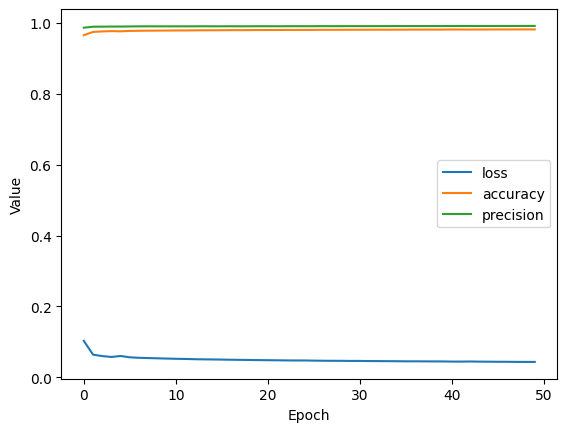

In [43]:

import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['precision'], label='precision')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


In [46]:
history = model.evaluate(X_test, y_test)

15876/15876 [==============================] - 96s 6ms/step - loss: 0.0601 - accuracy: 0.9778 - precision: 0.9896 - recall: 0.9701


In [50]:
model.save('models/training_model.h5')  # Save as HDF5 file
model.save('models/training_model')  # Save as SavedModel format
model.save('models/training_model.keras')  # Save as Keras format

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
res = model.predict(test_data, batch_size=2048)
def confusion_plot(roi,res,title=None, class_name=None):
    fig, ax = plot_confusion_matrix(conf_mat = confusion_matrix(roi,res), class_names = class_name, show_absolute=True, show_normed=True, hide_spines=False, hide_ticks=False, figsize=(10,10))
    plt.title(title+'\n Accuary=%f \nPrecision=%f \nRecall=%f \nF1_Score=%f '%(\
    accuracy_score(roi,res),\
    precision_score(roi,res, average='macro'),\
    recall_score(roi,res, average='macro'),\
    f1_score(roi,res, average='macro')\
))
    plt.show()
confusion_plot(res.argmax(axis=-1), test_res.argmax(axis=-1), 'Test output', data_43_type)